In [1]:
from datasets import load_dataset
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
from sklearn.model_selection import train_test_split
from transformers import Trainer, TrainingArguments
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, balanced_accuracy_score
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import DataLoader, Subset
from transformers import EarlyStoppingCallback
from sklearn.model_selection import StratifiedKFold 
import numpy as np
from datasets import Dataset, DatasetDict, ClassLabel

/home/elson/factcheck/lib/python3.6/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
dataset = load_dataset('csv',data_files='dataset_propositionattribution_nerfeatures.csv',delimiter=',',column_names=["claim","premise","label","category","count_bf","count_ca","count_dis","count_food","count_lipid","count_treat","pres_bf","pres_ca","pres_dis","pres_food","pres_lipid","pres_treat","counte_bf","counte_ca","counte_dis","counte_food","counte_lipid","counte_treat","prese_bf","prese_ca","prese_dis","prese_food","prese_lipid","prese_treat","url", "entities","entity_map","entity_map_ev","entities_ev","gem_exp","gem_label","gpt_label","gpt_exp","gold_exp","synonym","voice","split"],skiprows=1)

Using custom data configuration default-022bc67e9c58e92d
Reusing dataset csv (/home/elson/.cache/huggingface/datasets/csv/default-022bc67e9c58e92d/0.0.0/51cce309a08df9c4d82ffd9363bbe090bf173197fc01a71b034e8594995a1a58)
100%|██████████| 1/1 [00:00<00:00, 328.84it/s]


In [3]:
train_dataset = dataset['train'].filter(lambda example: example['split'] == 'train')
validation_dataset = dataset['train'].filter(lambda example: example['split'] == 'validation')
test_dataset = dataset['train'].filter(lambda example: example['split'] == 'test')
dataset = DatasetDict({
    'train': train_dataset,
    'val': validation_dataset,
    'test': test_dataset
})

Loading cached processed dataset at /home/elson/.cache/huggingface/datasets/csv/default-022bc67e9c58e92d/0.0.0/51cce309a08df9c4d82ffd9363bbe090bf173197fc01a71b034e8594995a1a58/cache-2b8e361375c0e153.arrow
Loading cached processed dataset at /home/elson/.cache/huggingface/datasets/csv/default-022bc67e9c58e92d/0.0.0/51cce309a08df9c4d82ffd9363bbe090bf173197fc01a71b034e8594995a1a58/cache-0cc9bb699c2761fb.arrow
Loading cached processed dataset at /home/elson/.cache/huggingface/datasets/csv/default-022bc67e9c58e92d/0.0.0/51cce309a08df9c4d82ffd9363bbe090bf173197fc01a71b034e8594995a1a58/cache-608a44ac65076739.arrow


In [4]:
columns_to_keep = ["claim", "premise", "label", "category","count_bf","count_ca","count_dis","count_food","count_lipid","count_treat","pres_bf","pres_ca","pres_dis","pres_food","pres_lipid","pres_treat"]
all_columns = dataset["train"].column_names

columns_to_drop = [col for col in all_columns if col not in columns_to_keep]
for split in dataset.keys():
    dataset[split] = dataset[split].remove_columns(columns_to_drop)

In [5]:
dataset["train"]["claim"]

['Myrrh essential oil is sometimes used in skincare products to help improve the appearance of the skin.',
 'cAMP causes vasoconstriction.',
 'Sprains are more common in children than adults.',
 'You can tighten your skin with a radiofrequency treatment.',
 'TD is a sign of mental illness.',
 'Chronic pain is all in your head.',
 'Swollen tonsils are a sign of infection.',
 'You can only donate blood if you are a certain weight.',
 'Dental implants are a good option for people who have lost teeth.',
 'Dehydration can cause headaches.',
 'Ultrasound is a safe and painless procedure.',
 'Salt is bad for your heart.',
 'Transurethral Microwave Thermotherapy (TUMT) is a minimally invasive procedure used to treat Benign Prostatic Hyperplasia (BPH).',
 'cGMP causes vasodilation.',
 'Even if you have the same condition as a friend or family member, using their prescription could be dangerous.',
 'Rheumatoid arthritis is caused by stress.',
 'TD is more common in children than adults.',
 'Mino

In [6]:
from datasets import load_dataset, DatasetDict

label2id = {
    "contradiction": 2,
    "entailment": 0,
    "neutral": 1
}

id2label = {v: k for k, v in label2id.items()}

label_mapping = {
    'SUPPORTED': 'entailment',
    'REFUTED': 'contradiction',
    'NOT ENOUGH INFORMATION': 'neutral'
}

def map_and_encode_labels(example):
    # Map original dataset labels to new labels ('entailment', 'contradiction', 'neutral')
    mapped_label = label_mapping[example['label']]
    # Encode mapped labels using label2id
    example['label'] = label2id[mapped_label]
    return example

for split in dataset.keys():
    dataset[split] = dataset[split].map(map_and_encode_labels)


# Show the label encoding mapping
print("Label Encoding Mapping:", label2id)

Loading cached processed dataset at /home/elson/.cache/huggingface/datasets/csv/default-022bc67e9c58e92d/0.0.0/51cce309a08df9c4d82ffd9363bbe090bf173197fc01a71b034e8594995a1a58/cache-18f96bf5c6176fc5.arrow
Loading cached processed dataset at /home/elson/.cache/huggingface/datasets/csv/default-022bc67e9c58e92d/0.0.0/51cce309a08df9c4d82ffd9363bbe090bf173197fc01a71b034e8594995a1a58/cache-6db4f01ca05878d4.arrow
Loading cached processed dataset at /home/elson/.cache/huggingface/datasets/csv/default-022bc67e9c58e92d/0.0.0/51cce309a08df9c4d82ffd9363bbe090bf173197fc01a71b034e8594995a1a58/cache-1a61e2b1bf2efa35.arrow


Label Encoding Mapping: {'contradiction': 2, 'entailment': 0, 'neutral': 1}


In [7]:
labels = np.array(dataset['train']['label'])

In [8]:
from transformers import AutoTokenizer
import torch.utils.data

class MediClaimDataset(torch.utils.data.Dataset):
    def __init__(self, dataset, tokenizer_name='MoritzLaurer/DeBERTa-v3-base-mnli-fever-anli'):
        self.dataset = dataset
        self.tokenizer = AutoTokenizer.from_pretrained(tokenizer_name)
    
    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, idx):
        idx = int(idx)  # Ensure idx is an integer
        item = self.dataset[idx]  # Access the dataset item at idx
        

        claim = item['claim']
        premise = item['premise'].lower().replace('\n', '').replace('[','').replace(']','')
        
        additional_features = [
            "count_bf","count_ca","count_dis","count_food","count_lipid","count_treat","pres_bf","pres_ca","pres_dis","pres_food","pres_lipid","pres_treat"]
    
        for feature in additional_features:
            if feature in item:
                claim += "[SEP]" + str(item[feature])
        
        additional_features_ev = [
            'counte_bf', 'counte_ca', 'counte_dis', 'counte_food', 'counte_lipid', 'counte_treat', 'prese_bf', 'prese_ca', 'prese_dis', 'prese_food', 'prese_lipid', 'prese_treat']
    
        for feature_ev in additional_features_ev:
            if feature_ev in item:
                premise += "[SEP]" + str(item[feature])
        item['claim']=claim
        item['premise']=premise        
        # Tokenize the texts
        inputs = self.tokenizer(
             premise, claim,
            return_tensors="pt",  # Ensure PyTorch tensors are returned
            padding='max_length',  # Apply padding to the maximum length
            truncation='longest_first',  # Truncate to the maximum length if necessary
            max_length=512,  # Specify the maximum length
            add_special_tokens=True  # Add special tokens like [CLS], [SEP]
        )
        
        item['input_ids'] = inputs['input_ids'].squeeze()  # Remove batch dimension
        item['attention_mask']= inputs['attention_mask'].squeeze() # Remove batch dimension
        
        output_item = {
            'input_ids': inputs['input_ids'].squeeze(),  # Remove batch dimension
            'attention_mask': inputs['attention_mask'].squeeze(),  # Remove batch dimension
            'claim': claim,  # Include augmented claim text
            'evidences': premise  # Include original evidence text
        }
        
        if 'label' in item:
            output_item['label'] = torch.tensor(item['label'], dtype=torch.long)
        
        return output_item




In [9]:
import torch
print(torch.cuda.device_count())
print("Available GPUs:")
for i in range(torch.cuda.device_count()):
    print(f"GPU {i}: {torch.cuda.get_device_name(i)}")

1
Available GPUs:
GPU 0: Tesla V100-SXM2-32GB


In [10]:
model_name = "MoritzLaurer/DeBERTa-v3-base-mnli-fever-anli"
tokenizer = AutoTokenizer.from_pretrained(model_name, model_max_length=512)
model = AutoModelForSequenceClassification.from_pretrained(model_name,
                                 num_labels=3, ignore_mismatched_sizes=True)
device = "cuda:0"
model.to(device)

DebertaV2ForSequenceClassification(
  (deberta): DebertaV2Model(
    (embeddings): DebertaV2Embeddings(
      (word_embeddings): Embedding(128100, 768, padding_idx=0)
      (LayerNorm): LayerNorm((768,), eps=1e-07, elementwise_affine=True)
      (dropout): StableDropout()
    )
    (encoder): DebertaV2Encoder(
      (layer): ModuleList(
        (0): DebertaV2Layer(
          (attention): DebertaV2Attention(
            (self): DisentangledSelfAttention(
              (query_proj): Linear(in_features=768, out_features=768, bias=True)
              (key_proj): Linear(in_features=768, out_features=768, bias=True)
              (value_proj): Linear(in_features=768, out_features=768, bias=True)
              (pos_dropout): StableDropout()
              (dropout): StableDropout()
            )
            (output): DebertaV2SelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-07, elementwise_affine=True)
 

In [11]:
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)

    f1 = f1_score(labels, preds, average="weighted")
    acc = accuracy_score(labels, preds)
    prec = precision_score(labels, preds, average="weighted")  # Specify average method
    recall = recall_score(labels, preds, average="weighted")  # Specify average method

    return {"accuracy": acc, "precision": prec, "recall": recall, "f1": f1}

In [12]:
dataset['train']

Dataset({
    features: ['claim', 'premise', 'label', 'category', 'count_bf', 'count_ca', 'count_dis', 'count_food', 'count_lipid', 'count_treat', 'pres_bf', 'pres_ca', 'pres_dis', 'pres_food', 'pres_lipid', 'pres_treat'],
    num_rows: 1623
})

In [13]:
import gc

torch.cuda.set_device(0)

# Clearing the cache
torch.cuda.empty_cache()
gc.collect()
# Checking GPU memory, making sure to reset peak memory stats
torch.cuda.reset_peak_memory_stats()

In [14]:
current_device = torch.cuda.current_device()
print(f"Current CUDA device: GPU {current_device}")

Current CUDA device: GPU 0


In [15]:
train_data = dataset['train']
eval_data = dataset['val']
model = model.to('cuda:0')

In [16]:
tdata = MediClaimDataset(train_data)
vdata = MediClaimDataset(eval_data)
test_data = MediClaimDataset(dataset['test'])

In [17]:
tdata.__getitem__(0)

{'input_ids': tensor([    1,   262,  1830,  6725,   265, 88609,   263, 98237,   993,   262,
         49462,   265,   262, 22003, 96579,   267,   262, 61462,   263,   575,
           262, 26217,   263,  9854,  1730,   264,   993,   262, 39632,   265,
           262,  1158,   263,  4843,   262,  7275,  1290,   260,     2,   573,
         52341,  1830,  1080,   269,  1359,   427,   267, 17847,   633,   264,
           408,  1300,   262,  2658,   265,   262,  1158,   260,     2,   767,
             2,   767,     2,   767,     2,   767,     2,   767,     2,   767,
             2,   767,     2,   767,     2,   767,     2,   767,     2,   767,
             2,   767,     2,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,   

In [18]:
from transformers import EarlyStoppingCallback, Trainer, TrainingArguments,DataCollatorWithPadding


data_collator = DataCollatorWithPadding(tokenizer=tokenizer, padding=True)


training_args = TrainingArguments(
    output_dir=f'/home/elson/2.4.5_deberta/',
    num_train_epochs=20,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    dataloader_pin_memory=True,
    dataloader_num_workers=4,
    fp16=True,
    warmup_ratio=0.1,
    weight_decay=0.1,
    logging_steps=10,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=1,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    report_to="none"
)

trainer = Trainer(
    model=model.to(device),
    args=training_args,
    train_dataset=tdata,
    eval_dataset=vdata,
    #tokenizer=tokenizer,
    #data_collator = data_collator,
    compute_metrics=compute_metrics
    #callbacks=[EarlyStoppingCallback(early_stopping_patience=3, early_stopping_threshold=0.01)]
)

# Training and Evaluation
trainer.train()
eval_result = trainer.evaluate(vdata)

# Save the best model and tokenizer
model.save_pretrained(f'/home/elson/2.4.5_deberta/best_model')
tokenizer.save_pretrained(f'/home/elson/2.4.5_deberta/best_model')


Using amp half precision backend
/home/elson/factcheck/lib/python3.6/site-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 1623
  Num Epochs = 20
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 2040


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.724300,0.795981,0.679570,0.683284,0.679570,0.660024
2,0.564700,0.986017,0.619355,0.686300,0.619355,0.639406
3,0.358400,1.023106,0.662366,0.685393,0.662366,0.670568
4,0.227200,1.318376,0.615054,0.711620,0.615054,0.640616
5,0.298600,1.231840,0.662366,0.670719,0.662366,0.663765
6,0.247400,1.310946,0.634409,0.648505,0.634409,0.640681
7,0.099300,2.157298,0.591398,0.695223,0.591398,0.617163
8,0.046400,2.184891,0.645161,0.684533,0.645161,0.659991
9,0.123900,2.173608,0.630108,0.676710,0.630108,0.640855
10,0.075100,2.136609,0.668817,0.701830,0.668817,0.681283


***** Running Evaluation *****
  Num examples = 465
  Batch size = 16
Saving model checkpoint to /home/elson/2.4.5_deberta/checkpoint-102
Configuration saved in /home/elson/2.4.5_deberta/checkpoint-102/config.json
Model weights saved in /home/elson/2.4.5_deberta/checkpoint-102/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 465
  Batch size = 16
Saving model checkpoint to /home/elson/2.4.5_deberta/checkpoint-204
Configuration saved in /home/elson/2.4.5_deberta/checkpoint-204/config.json
Model weights saved in /home/elson/2.4.5_deberta/checkpoint-204/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 465
  Batch size = 16
Saving model checkpoint to /home/elson/2.4.5_deberta/checkpoint-306
Configuration saved in /home/elson/2.4.5_deberta/checkpoint-306/config.json
Model weights saved in /home/elson/2.4.5_deberta/checkpoint-306/pytorch_model.bin
Deleting older checkpoint [/home/elson/2.4.5_deberta/checkpoint-204] due to args.save_total_limit
***** Running 

Configuration saved in /home/elson/2.4.5_deberta/best_model/config.json
Model weights saved in /home/elson/2.4.5_deberta/best_model/pytorch_model.bin
tokenizer config file saved in /home/elson/2.4.5_deberta/best_model/tokenizer_config.json
Special tokens file saved in /home/elson/2.4.5_deberta/best_model/special_tokens_map.json
added tokens file saved in /home/elson/2.4.5_deberta/best_model/added_tokens.json


('/home/elson/2.4.5_deberta/best_model/tokenizer_config.json',
 '/home/elson/2.4.5_deberta/best_model/special_tokens_map.json',
 '/home/elson/2.4.5_deberta/best_model/spm.model',
 '/home/elson/2.4.5_deberta/best_model/added_tokens.json')

In [19]:
model_path = "/home/elson/2.4.5_deberta/best_model/"
model = AutoModelForSequenceClassification.from_pretrained(model_path).to('cuda:0')

# Evaluate on the test set
test_results = trainer.predict(test_data)

loading configuration file /home/elson/2.4.5_deberta/best_model/config.json
Model config DebertaV2Config {
  "_name_or_path": "/home/elson/2.4.5_deberta/best_model/",
  "architectures": [
    "DebertaV2ForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "entailment",
    "1": "neutral",
    "2": "contradiction"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "contradiction": 2,
    "entailment": 0,
    "neutral": 1
  },
  "layer_norm_eps": 1e-07,
  "max_position_embeddings": 512,
  "max_relative_positions": -1,
  "model_type": "deberta-v2",
  "norm_rel_ebd": "layer_norm",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "pooler_dropout": 0,
  "pooler_hidden_act": "gelu",
  "pooler_hidden_size": 768,
  "pos_att_type": [
    "p2c",
    "c2p"
  ],
  "position_biased_input": false,
  "position_buckets": 256,

In [20]:
print(test_results)

PredictionOutput(predictions=array([[ 1.4082e+00, -9.5825e-02, -1.2744e+00],
       [ 1.1758e+00, -2.7148e-01, -9.4922e-01],
       [ 1.9873e+00, -7.4512e-01, -1.2285e+00],
       [-1.0078e+00, -7.4609e-01,  1.6973e+00],
       [ 1.4268e+00,  1.7200e-01, -1.6221e+00],
       [ 2.6699e+00, -6.3525e-01, -1.9287e+00],
       [ 1.6660e+00, -7.2998e-01, -9.7705e-01],
       [ 1.3379e+00, -3.1250e-01, -1.0439e+00],
       [ 1.5830e+00, -2.7734e-01, -1.2793e+00],
       [ 1.8350e+00, -7.2510e-01, -1.0781e+00],
       [ 1.6523e+00, -7.1729e-01, -9.5215e-01],
       [ 2.4824e+00, -8.5449e-01, -1.5576e+00],
       [ 6.6113e-01,  2.1802e-01, -8.6865e-01],
       [ 2.0215e+00, -6.4062e-01, -1.3379e+00],
       [ 1.6377e+00, -3.0786e-01, -1.3467e+00],
       [-8.7012e-01, -1.3489e-01,  1.0088e+00],
       [ 7.5830e-01,  4.8755e-01, -1.3496e+00],
       [ 2.8711e+00, -7.4951e-01, -1.9824e+00],
       [ 2.2344e+00, -6.8359e-01, -1.5098e+00],
       [ 1.9688e+00, -4.7681e-01, -1.4463e+00],
       [-1.

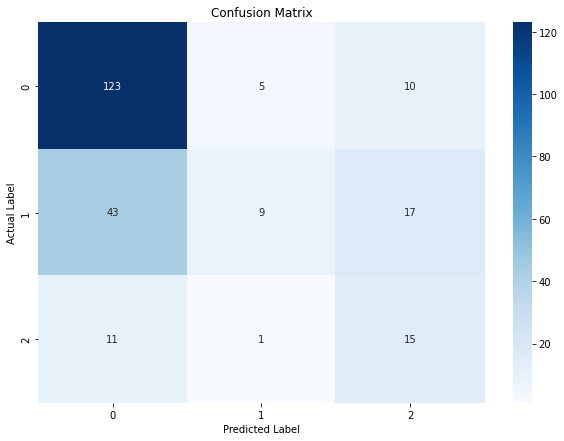

In [21]:
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
probabilities = torch.softmax(torch.tensor(test_results.predictions).to(torch.float32), dim=-1)
predictions = np.argmax(probabilities.numpy(), axis=1)
true_labels = test_results.label_ids
cm = confusion_matrix(true_labels, predictions)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.ylabel("Actual Label")
plt.xlabel("Predicted Label")
plt.show()

In [22]:
import pandas as pd
data_to_save = []
for idx in range(len(test_data)):
    item = dataset['test'][idx]
    actual_label = item['label']
    predicted_label = predictions[idx]
    claim = item['claim'] 
    premise = item['premise'] 
    category = item['category']
    
    # Append the information as a dictionary to the list
    data_to_save.append({
        'Claim': claim,
        'Premise': premise,
        'Actual Label': actual_label,
        'Predicted Label': predicted_label,
        'Category' : category
    })

df = pd.DataFrame(data_to_save)

# Save the DataFrame to a CSV file
df.to_csv('/home/elson/results/2.4.5_results.csv', index=False)

In [23]:
# Calculate correctly classified instances
correctly_classified = df[df['Actual Label'] == df['Predicted Label']]

# Calculate misclassified instances
misclassified = df[df['Actual Label'] != df['Predicted Label']]

# Count the number of correctly classified and misclassified by category
correct_classification_counts = correctly_classified['Category'].value_counts()
misclassification_counts = misclassified['Category'].value_counts()

In [24]:
correct_classification_counts

General Health           39
Fitness                  12
Bone health              12
Diabetes                  9
Cancer                    9
Throat                    9
Skin                      9
Neurological health       8
COVID                     6
Ear                       6
Cardiovascular Health     6
Men's health              6
Women' s Health           4
Blood                     4
Mental Health             3
Hair                      2
Eye                       2
Muscles                   1
Name: Category, dtype: int64

In [25]:
misclassification_counts

Skin                     15
General Health           12
Hair                     10
Bone health               9
Eye                       7
Cardiovascular Health     6
Muscles                   5
Blood                     5
Vascular                  3
Diabetes                  3
Fitness                   3
Cancer                    3
Dental Health             3
Women' s Health           2
Neurological health       1
Name: Category, dtype: int64